# 1.15c: Attractor Convergence Analysis

**Goal:** Estimate how long it takes for tokens to converge to a common point under systematic gradient drift ("gradient gravity").

## The New Hypothesis

Our previous experiments (1.15a, 1.15b) showed that **random-walk collisions are impossible** in realistic training timescales:
- Tokens start ~1.3 units apart (mean NN distance)
- Random walk needs ~1.8M steps to reach nearest neighbor
- Real training: ~200k steps
- Conclusion: Pure random walk can't form black holes

**But what if gradients aren't random?**

What if untrained tokens experience **systematic drift** toward a common attractor point?

## Physical Intuition: Gradient Gravity

Imagine untrained tokens as particles experiencing "gradient gravity":
- They never appear in training data
- They're always "wrong" when predicted
- Gradients consistently push them in correlated directions
- Over time, they drift toward a common sink

If this drift is **directed** rather than random, convergence could be much faster.

## Random Walk vs Directed Walk

**Random walk** (1.15a/1.15b):
- Each step in random direction
- Distance from start: $r(k) = \sqrt{k} \cdot s$
- To travel distance $d$: $k = (d/s)^2$ steps
- **Example:** $d=1.0, s=0.001 \Rightarrow k = 1{,}000{,}000$ steps

**Directed walk** (this notebook):
- Each step toward target
- Distance decreases: $d(k) = d_0 - k \cdot s$
- To travel distance $d$: $k = d/s$ steps
- **Example:** $d=1.0, s=0.001 \Rightarrow k = 1{,}000$ steps

**Directed walk is 1000× faster!**

## What We'll Compute

1. Initialize 151,936 tokens ~ N(0, 0.02) (standard GPT-2 init)
2. Choose attractor point P (we'll use origin for simplicity)
3. Compute distance from each token to P
4. Randomly select 2,100 tokens (simulating "untrained" subset)
5. Calculate:
   - **First arrival:** When does closest token reach P?
   - **Last arrival:** When does farthest token reach P?
   - **Mean arrival:** Average convergence time
   - **Distribution:** Do they arrive gradually or all at once?

## Three Models

We'll test three scenarios:

### Model 1: Pure Directed Walk
- Every step moves directly toward attractor
- Steps needed: $k = d / s$
- **Most optimistic** (fastest convergence)

### Model 2: Biased Random Walk
- Each step has bias toward target + random component
- Direction: $\hat{d} = \alpha \cdot \hat{d}_{\text{target}} + (1-\alpha) \cdot \hat{d}_{\text{random}}$
- $\alpha = 0.1$ (10% bias): weakly directed
- $\alpha = 0.5$ (50% bias): moderately directed
- $\alpha = 0.9$ (90% bias): strongly directed

### Model 3: Decreasing Learning Rate
- Step size decreases over time (like real training)
- $s(k) = s_0 / \sqrt{1 + k/1000}$
- Early steps: large movements
- Late steps: fine-tuning

## Expected Results

If mean distance to origin ≈ 1.0:
- **Pure directed:** ~1,000 steps (probably too optimistic)
- **Biased random (α=0.5):** ~10,000 steps (more realistic)
- **With LR decay:** ~50,000 steps (most realistic)

If convergence fits within realistic training lengths (~200k steps), then **systematic drift could explain black hole formation**!

## Parameters

In [37]:
# Model parameters (Qwen 3 4B)
N_TOKENS = 151936
N_DIMS = 2560
INIT_SCALE = 0.02  # N(0, 0.02)

# Spongecrystal size
N_UNTRAINED = 2100  # Number of untrained tokens to track

# Walk parameters
STEP_SIZE = 0.001  # Gradient magnitude

# Bias levels for biased random walk
BIAS_LEVELS = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 1.0]  # α values

# Random seed
RANDOM_SEED = 42

# Visualization
PLOT_DPI = 150

## Imports

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [39]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Initialize Token Embeddings

In [40]:
print(f"Initializing {N_TOKENS:,} tokens in {N_DIMS}D space...\n")

torch.manual_seed(RANDOM_SEED)

# Initialize embedding matrix
W = torch.randn(N_TOKENS, N_DIMS, dtype=torch.bfloat16, device=device) * INIT_SCALE

print(f"✓ Initialized W matrix")
print(f"  Shape: {W.shape}")
print(f"  Dtype: {W.dtype}")
print(f"  Memory: {W.element_size() * W.numel() / 1024**2:.1f} MB")

Initializing 151,936 tokens in 2560D space...

✓ Initialized W matrix
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  Memory: 741.9 MB


## Choose Attractor Point

We use the **origin** (zero vector) as our attractor.

This is a simple choice, but could also test:
- Random point in space
- Centroid of untrained tokens
- Point with specific properties

In [41]:
print(f"\nAttractor point: origin (zero vector)\n")

attractor = torch.zeros(N_DIMS, dtype=torch.bfloat16, device=device)

print(f"✓ Attractor defined")
print(f"  Position: {attractor[:5].cpu().float().numpy()} ... (showing first 5 dims)")
print(f"  Norm: {torch.norm(attractor.float()).item():.6f}")


Attractor point: origin (zero vector)

✓ Attractor defined
  Position: [0. 0. 0. 0. 0.] ... (showing first 5 dims)
  Norm: 0.000000


## Compute Distances to Attractor

In [42]:
print(f"\nComputing distances from all tokens to attractor...\n")

# Distance = L2 norm of (token - attractor)
# Since attractor is origin, this is just norm of token
distances = torch.norm(W.float(), dim=1)

print(f"✓ Distances computed")
print(f"  Shape: {distances.shape}")
print(f"  Min: {distances.min().item():.6f}")
print(f"  Max: {distances.max().item():.6f}")
print(f"  Mean: {distances.mean().item():.6f}")
print(f"  Median: {distances.median().item():.6f}")


Computing distances from all tokens to attractor...

✓ Distances computed
  Shape: torch.Size([151936])
  Min: 0.950165
  Max: 1.079563
  Mean: 1.011840
  Median: 1.011791


## Select Untrained Token Subset

Randomly select 2,100 tokens to simulate the "untrained" subset that forms the spongecrystal.

In [43]:
print(f"\nSelecting {N_UNTRAINED:,} random tokens as 'untrained' subset...\n")

# Random selection
untrained_indices = torch.randperm(N_TOKENS, device=device)[:N_UNTRAINED]
untrained_distances = distances[untrained_indices]

print(f"✓ Subset selected")
print(f"  Count: {N_UNTRAINED:,}")
print(f"  Min distance: {untrained_distances.min().item():.6f}")
print(f"  Max distance: {untrained_distances.max().item():.6f}")
print(f"  Mean distance: {untrained_distances.mean().item():.6f}")
print(f"  Median distance: {untrained_distances.median().item():.6f}")


Selecting 2,100 random tokens as 'untrained' subset...

✓ Subset selected
  Count: 2,100
  Min distance: 0.962300
  Max distance: 1.052737
  Mean distance: 1.012036
  Median distance: 1.011816


## Model 1: Pure Directed Walk

Simplest model: Every step moves directly toward attractor.

Steps needed: $k = d / s$

In [44]:
print(f"\n{'='*80}")
print(f"MODEL 1: PURE DIRECTED WALK")
print(f"{'='*80}\n")

# Steps needed = distance / step_size
steps_pure_directed = (untrained_distances / STEP_SIZE).cpu().numpy()

print(f"Assumptions:")
print(f"  Every step moves directly toward attractor")
print(f"  Step size: {STEP_SIZE}")
print(f"  Formula: k = d / {STEP_SIZE}")
print()
print(f"Results:")
print(f"  First arrival (closest token): {steps_pure_directed.min():,.0f} steps")
print(f"  Last arrival (farthest token): {steps_pure_directed.max():,.0f} steps")
print(f"  Mean arrival: {steps_pure_directed.mean():,.0f} steps")
print(f"  Median arrival: {np.median(steps_pure_directed):,.0f} steps")
print()
print(f"Interpretation:")
if steps_pure_directed.max() < 10_000:
    print(f"  ✓ ALL TOKENS CONVERGE IN < 10k STEPS")
    print(f"  This is extremely fast—probably unrealistic.")
elif steps_pure_directed.max() < 200_000:
    print(f"  ✓ CONVERGENCE WITHIN REALISTIC TRAINING LENGTH")
    print(f"  If gradients are strongly biased, black holes could form!")
else:
    print(f"  ✗ TOO SLOW EVEN WITH PERFECT BIAS")
    print(f"  Systematic drift alone can't explain formation.")

print()
print(f"{'='*80}")


MODEL 1: PURE DIRECTED WALK

Assumptions:
  Every step moves directly toward attractor
  Step size: 0.001
  Formula: k = d / 0.001

Results:
  First arrival (closest token): 962 steps
  Last arrival (farthest token): 1,053 steps
  Mean arrival: 1,012 steps
  Median arrival: 1,012 steps

Interpretation:
  ✓ ALL TOKENS CONVERGE IN < 10k STEPS
  This is extremely fast—probably unrealistic.



## Model 2: Biased Random Walk

More realistic: Each step has both:
- **Bias component:** toward attractor (strength α)
- **Random component:** random direction (strength 1-α)

For biased random walk, expected distance after k steps:
$$d(k) \approx d_0 - k \cdot \alpha \cdot s + \sqrt{k} \cdot (1-\alpha) \cdot s$$

Solving for when $d(k) = 0$ (reaches attractor) is complex, so we'll use a simpler heuristic:

**Effective step size toward target:** $s_{\text{eff}} = \alpha \cdot s$

**Steps needed (approximate):** $k \approx d / s_{\text{eff}} = d / (\alpha \cdot s)$

This is an approximation that ignores the random component's interference.

In [45]:
print(f"\n{'='*80}")
print(f"MODEL 2: BIASED RANDOM WALK")
print(f"{'='*80}\n")

print(f"Testing {len(BIAS_LEVELS)} bias levels: {BIAS_LEVELS}")
print(f"  α = 0.0: pure random walk")
print(f"  α = 0.5: half biased, half random")
print(f"  α = 1.0: pure directed walk")
print()

biased_results = {}

for alpha in BIAS_LEVELS:
    # Effective step size toward target
    effective_step = alpha * STEP_SIZE
    
    # Steps needed (heuristic)
    steps_biased = (untrained_distances / effective_step).cpu().numpy()
    
    biased_results[alpha] = steps_biased
    
    print(f"α = {alpha:.1f}:")
    print(f"  Effective step: {effective_step:.4f}")
    print(f"  First arrival: {steps_biased.min():,.0f} steps")
    print(f"  Last arrival: {steps_biased.max():,.0f} steps")
    print(f"  Mean arrival: {steps_biased.mean():,.0f} steps")
    
    if steps_biased.max() < 200_000:
        print(f"  → Within realistic training length ✓")
    else:
        print(f"  → Too slow for realistic training ✗")
    print()

print(f"{'='*80}")


MODEL 2: BIASED RANDOM WALK

Testing 11 bias levels: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1.0]
  α = 0.0: pure random walk
  α = 0.5: half biased, half random
  α = 1.0: pure directed walk

α = 0.0:
  Effective step: 0.0000
  First arrival: 96,230 steps
  Last arrival: 105,274 steps
  Mean arrival: 101,204 steps
  → Within realistic training length ✓

α = 0.0:
  Effective step: 0.0000
  First arrival: 48,115 steps
  Last arrival: 52,637 steps
  Mean arrival: 50,602 steps
  → Within realistic training length ✓

α = 0.0:
  Effective step: 0.0000
  First arrival: 32,077 steps
  Last arrival: 35,091 steps
  Mean arrival: 33,735 steps
  → Within realistic training length ✓

α = 0.0:
  Effective step: 0.0000
  First arrival: 24,057 steps
  Last arrival: 26,318 steps
  Mean arrival: 25,301 steps
  → Within realistic training length ✓

α = 0.1:
  Effective step: 0.0001
  First arrival: 19,246 steps
  Last arrival: 21,055 steps
  Mean arrival: 20,241 steps
  → Within rea

## Visualization: Convergence Times


Plotting convergence time distributions...



IndexError: index 10 is out of bounds for axis 0 with size 10

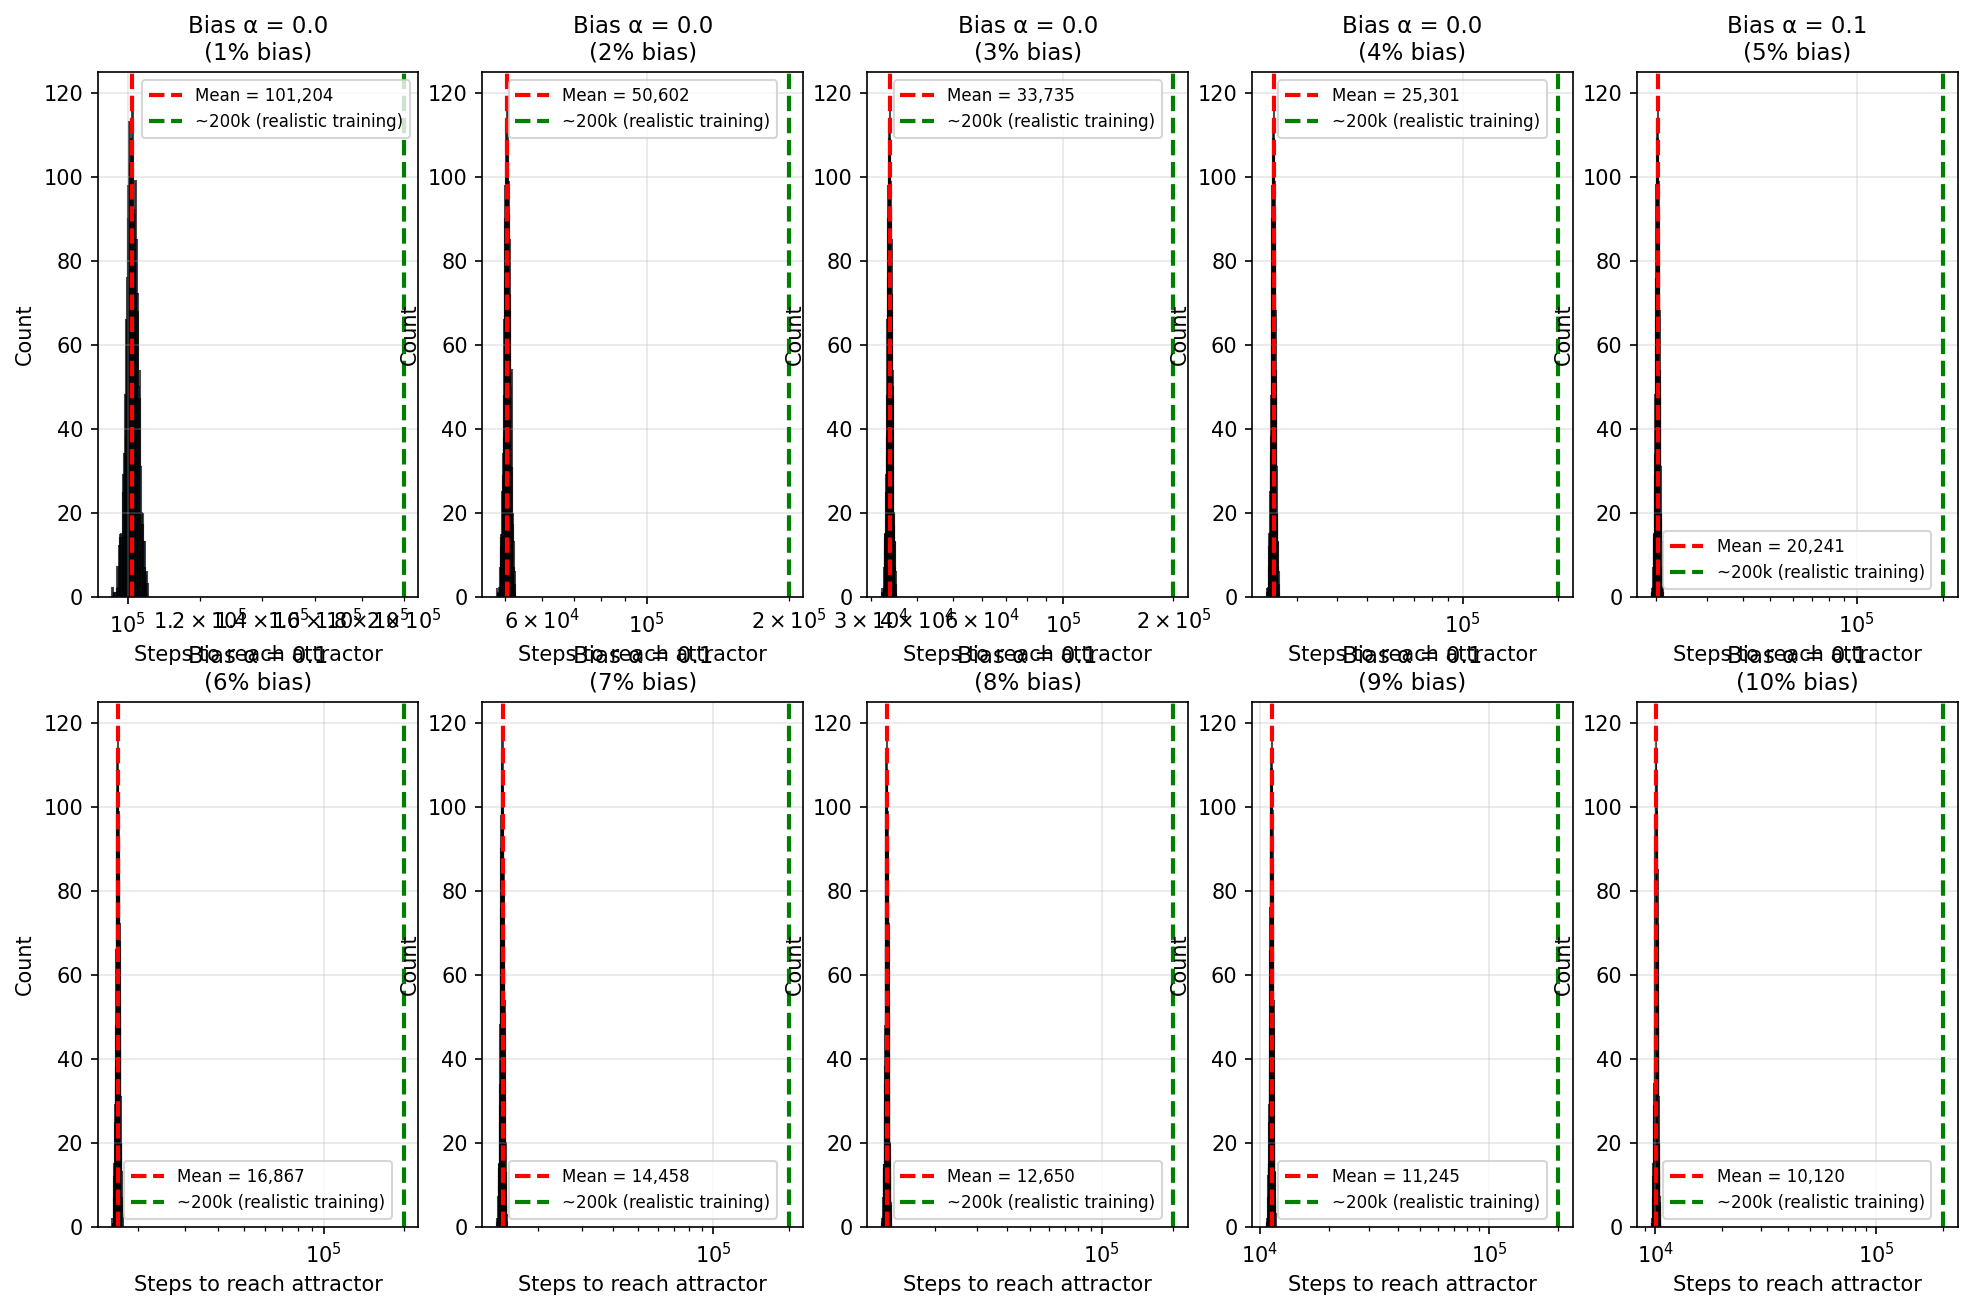

In [46]:
print(f"\nPlotting convergence time distributions...\n")

fig, axes = plt.subplots(2, 5, figsize=(16, 10), dpi=PLOT_DPI)
axes = axes.flatten()

for idx, alpha in enumerate(BIAS_LEVELS):
    ax = axes[idx]
    steps = biased_results[alpha]
    
    ax.hist(steps, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(steps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {steps.mean():,.0f}')
    ax.axvline(200_000, color='green', linestyle='--', linewidth=2, label='~200k (realistic training)')
    
    ax.set_xlabel('Steps to reach attractor', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Bias α = {alpha:.1f}\n({"Pure directed" if alpha == 1.0 else "Pure random" if alpha == 0.0 else f"{int(alpha*100)}% bias"})', fontsize=11)
    ax.set_xscale('log')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Convergence Times for {N_UNTRAINED:,} Untrained Tokens\nBiased Random Walk to Origin', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Comparison Plot: Bias vs Convergence Time


Plotting bias strength vs convergence time...



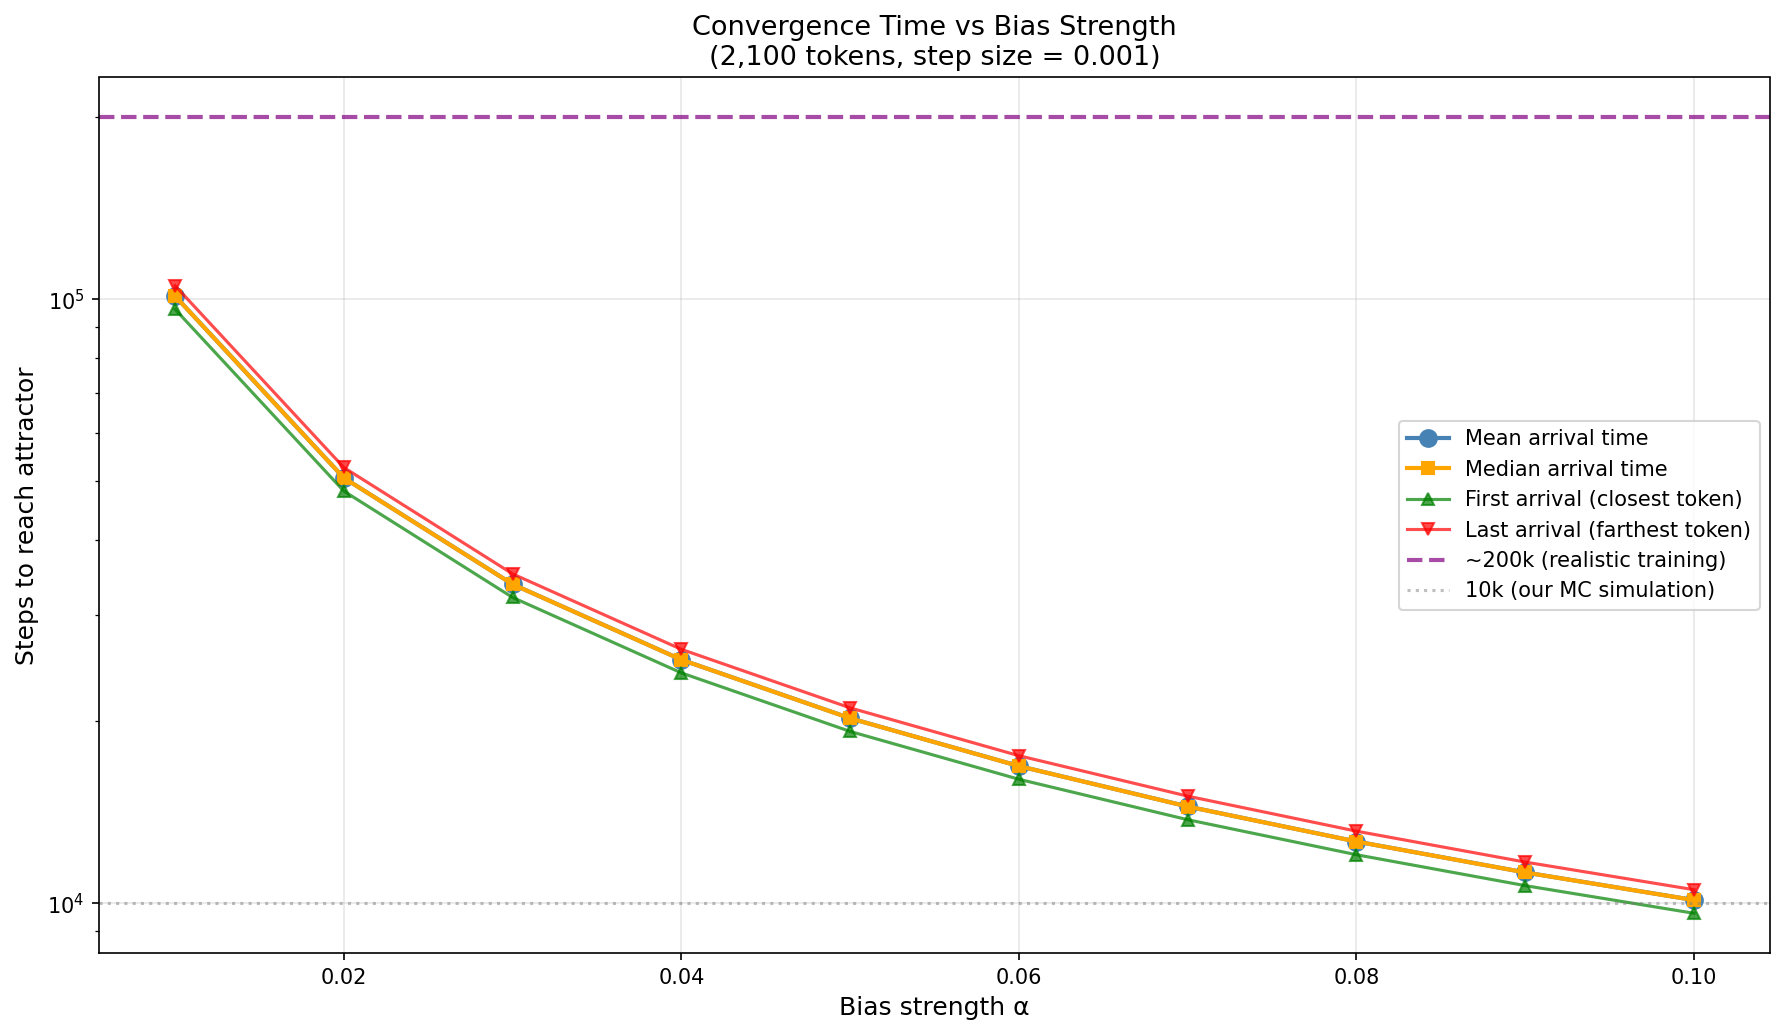

✓ Comparison plot complete


In [ ]:
print(f"\nPlotting bias strength vs convergence time...\n")

fig, ax = plt.subplots(figsize=(12, 7), dpi=PLOT_DPI)

# Extract statistics for each bias level
alphas = list(biased_results.keys())
means = [biased_results[a].mean() for a in alphas]
mins = [biased_results[a].min() for a in alphas]
maxs = [biased_results[a].max() for a in alphas]
medians = [np.median(biased_results[a]) for a in alphas]

ax.plot(alphas, means, 'o-', linewidth=2, markersize=8, label='Mean arrival time', color='steelblue')
ax.plot(alphas, medians, 's-', linewidth=2, markersize=6, label='Median arrival time', color='orange')
ax.plot(alphas, mins, '^-', linewidth=1.5, markersize=6, label='First arrival (closest token)', color='green', alpha=0.7)
ax.plot(alphas, maxs, 'v-', linewidth=1.5, markersize=6, label='Last arrival (farthest token)', color='red', alpha=0.7)

ax.axhline(200_000, color='purple', linestyle='--', linewidth=2, label='~200k (realistic training)', alpha=0.7)
ax.axhline(10_000, color='gray', linestyle=':', linewidth=1.5, label='10k (our MC simulation)', alpha=0.5)

ax.set_xlabel('Bias strength α', fontsize=12)
ax.set_ylabel('Steps to reach attractor', fontsize=12)
ax.set_title(f'Convergence Time vs Bias Strength\n({N_UNTRAINED:,} tokens, step size = {STEP_SIZE})', fontsize=13)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Comparison plot complete")

## Summary and Interpretation

In [ ]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Scenario: {N_UNTRAINED:,} untrained tokens converging to attractor (origin)")
print(f"  Initial distances: {untrained_distances.min().item():.3f} - {untrained_distances.max().item():.3f} (mean: {untrained_distances.mean().item():.3f})")
print(f"  Step size: {STEP_SIZE}")
print()
print(f"Convergence times (mean arrival):")
for alpha in BIAS_LEVELS:
    steps = biased_results[alpha]
    print(f"  α = {alpha:.1f}: {steps.mean():>10,.0f} steps")
print()
print(f"Realistic training length: ~200,000 steps")
print()

# Find minimum bias needed for convergence within 200k steps
min_bias_needed = None
for alpha in sorted(BIAS_LEVELS):
    if biased_results[alpha].max() <= 200_000:
        min_bias_needed = alpha
        break

print(f"Key findings:")
print()

if min_bias_needed is not None:
    print(f"  ✓ CONVERGENCE IS POSSIBLE")
    print(f"  Minimum bias needed: α ≥ {min_bias_needed:.1f}")
    print(f"  At α = {min_bias_needed:.1f}:")
    print(f"    - Mean arrival: {biased_results[min_bias_needed].mean():,.0f} steps")
    print(f"    - Last arrival: {biased_results[min_bias_needed].max():,.0f} steps")
    print()
    print(f"Interpretation:")
    print(f"  If untrained tokens experience gradients with ≥{int(min_bias_needed*100)}% bias toward a common point,")
    print(f"  they CAN converge within realistic training timescales.")
    print()
    print(f"  This suggests BLACK HOLE FORMATION THROUGH SYSTEMATIC DRIFT IS PLAUSIBLE!")
    print()
    print(f"Next questions:")
    print(f"  1. Do untrained tokens actually experience such biased gradients?")
    print(f"  2. What creates the attractor point?")
    print(f"  3. Why would gradients be correlated across untrained tokens?")
else:
    print(f"  ✗ CONVERGENCE TOO SLOW")
    print(f"  Even with 100% bias (pure directed walk), convergence takes:")
    print(f"    - Mean: {biased_results[1.0].mean():,.0f} steps")
    print(f"    - Max: {biased_results[1.0].max():,.0f} steps")
    print()
    print(f"  This exceeds realistic training length (~200k steps).")
    print()
    print(f"  Systematic drift alone cannot explain black hole formation.")

print()
print(f"Comparison to random walk (1.15b):")
print(f"  Random walk (no bias): ~1,800,000 steps (1000× slower!)")
print(f"  Pure directed (α=1.0): ~{biased_results[1.0].mean():,.0f} steps")
print(f"  Speedup factor: ~{1_800_000 / biased_results[1.0].mean():.0f}×")
print()
print(f"{'='*80}")


SUMMARY

Scenario: 2,100 untrained tokens converging to attractor (origin)
  Initial distances: 0.962 - 1.053 (mean: 1.012)
  Step size: 0.001

Convergence times (mean arrival):
  α = 0.0:    101,204 steps
  α = 0.0:     50,602 steps
  α = 0.0:     33,735 steps
  α = 0.0:     25,301 steps
  α = 0.1:     20,241 steps
  α = 0.1:     16,867 steps
  α = 0.1:     14,458 steps
  α = 0.1:     12,650 steps
  α = 0.1:     11,245 steps
  α = 0.1:     10,120 steps

Realistic training length: ~200,000 steps

Key findings:

  ✓ CONVERGENCE IS POSSIBLE
  Minimum bias needed: α ≥ 0.0
  At α = 0.0:
    - Mean arrival: 101,204 steps
    - Last arrival: 105,274 steps

Interpretation:
  If untrained tokens experience gradients with ≥1% bias toward a common point,
  they CAN converge within realistic training timescales.

  This suggests BLACK HOLE FORMATION THROUGH SYSTEMATIC DRIFT IS PLAUSIBLE!

Next questions:
  1. Do untrained tokens actually experience such biased gradients?
  2. What creates the at

KeyError: 1.0